In [3]:
import pandas as pd
import csv
import tweepy
import numpy as np
from textblob import TextBlob
import datetime
import time

In [2]:
btc = pd.read_csv('coindesk-bpi-USD-close_data-2010-07-17_2018-04-06.csv')

In [3]:
btc.head()

,Date,Close Price
0,2010-07-18 00:00:00,0.09
1,2010-07-19 00:00:00,0.08
2,2010-07-20 00:00:00,0.07
3,2010-07-21 00:00:00,0.08
4,2010-07-22 00:00:00,0.05


In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 2 columns):
Date           2823 non-null object
Close Price    2821 non-null float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


In [4]:
import csv
import math
import re
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from bs4 import BeautifulSoup
from keras.layers import Dense, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from nltk.corpus import stopwords   # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob

/Users/guptasoumya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/guptasoumya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [22]:
seed = 7
np.random.seed(seed)

# API keys
CONSUMER_KEY = 'lH2fLuyVlvPW75bW5Mf38acbH'
CONSUMER_SECRET = 'HjTwBBOIsFozYT6f2vK8Oj0c60c8kbjkEsopHMbxcMOslOUKPI'

ACCESS_TOKEN = '93781707-ylFK5ZDGoxtmA5vKVYlfYQasggRFYv8Y2Kr3zvQHF'
ACCESS_TOKEN_SECRET = 'kDCCoGuPkmda00SBYcBaK4tWqsl2LNQeAy0jBaQQafJ8v'

In [6]:
# Save global filename
filename = time.strftime("%Y-%m-%d-%H-%M-%S")

# Uncomment to store results into assets/data/training_results directory
# instead of printing on the console.
# sys.stdout = open("assets/data/training_results/" + filename + ".txt", 'a')

# Price training and testing set
prices_train_test = []

# Tweet sentiment training and testing set
tweets_train_test = []


In [26]:
# Twitter authentication and search
def twitter_search(text, limit=20):
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    
    print('Accessing Twitter API..\n')
    api = tweepy.API(auth, wait_on_rate_limit_notify=True)
    tweets = []
    
    # Define a threshold for each sentiment to classify each
    # as positive(1) or negative(0).
    threshold = 0.1
    pos_tweets = 0
    neg_tweets = 0
    
    print('Querying Twitter...\n')
    # Each word in the lexicon has scores for:
    # 1)     polarity: negative vs. positive    (-1.0 => +1.0)
    # 2) subjectivity: objective vs. subjective (+0.0 => +1.0)
    # 3)    intensity: modifies next word?      (x0.5 => x2.0)
    for tweet in limit_handled(tweepy.Cursor(api.search, q=text, result_type="recent", lang="en").items(limit)):
        analysis = TextBlob(tweet.text)
        api = tweepy.API(auth, wait_on_rate_limit=True)
        
        if analysis.sentiment.polarity >= threshold:
            polarity_flag = 1
            pos_tweets += 1
        else:
            polarity_flag = 0
            neg_tweets += 1
        
        tweets.append({'created_at': tweet.created_at,
                       'polarity': analysis.sentiment.polarity,
                       'subjectivity': analysis.sentiment.subjectivity,
                       'sentiment': polarity_flag,
                       'tweet': beautify_tweet(tweet.text)})
    if pos_tweets > neg_tweets:
        print('Overall Positive\n')
    else:
        print('Overall Negative\n')
    
    # Write tweets to cvs file
    write_tweets(tweets)

    # Create bag of words. Making tweets into vectors. max_features 5 ratio
    vector_tweets = create_vector_of_tweets(tweets, int(limit/5))
    
    # Train and predict using models
    predict_tweets(vector_tweets, limit)
    
    return


In [8]:
# Maintains twitter api threshold
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Stabilizing api search threshold...')
            time.sleep(15 * 60)

In [9]:
def beautify_tweet(raw_tweet):
    # Function to convert a raw tweet to a string of words
    # The input is a single string (a raw tweet), and
    # the output is a single string (a preprocessed tweet)
    #
    # 1. Remove HTML
    tweet_text = BeautifulSoup(raw_tweet, "lxml").get_text()
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]",      # The patttern to search for
                          " ",              # The pattern to replace it with
                          tweet_text)       # The text to search
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #    a list, so convert the stop words to a set
    # stops = set(stopwords.words("english"))
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stopwords.words("english")]

    #
    # 6. Join the words back into one string separated by space,
    #    and return the results.
    return( " ".join( meaningful_words ))



In [10]:
def create_vector_of_tweets(tweets, max_features=100):
    print("Creating the vector tweets...\n")
    clean_train_tweets = []
    for tweet in tweets:
        clean_train_tweets.append(tweet['tweet'])
        
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.
    vectorizer = CountVectorizer(analyzer="word",
                                 tokenizer=None,
                                 preprocessor=None,
                                 stop_words=None,
                                 max_features=max_features)
    
    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of
    # strings.
    train_data_features = vectorizer.fit_transform(clean_train_tweets)
    
    # Numpy arrays are easy to work with, so convert the result to an
    # array
    train_data_features = train_data_features.toarray()
    
    for i in range(0, len(train_data_features)):
        tweets[i]['tweet'] = train_data_features[i]
    
    # Sum up the counts of each vocabulary word
    dist = np.sum(train_data_features, axis=0)
    
    # For each, print the vocabulary word and the number of times it
    # appears in the training set
    print("Vocabulary word count and word\n")
    vocab = vectorizer.get_feature_names()
    print("Count  Word")
    for tag, count in zip(vocab, dist):
        print(count, tag)
    print('\n')
    
    return tweets


In [24]:
# Stores tweets
def write_tweets(tweets_data):
    # Open/Create a file to append data
    with open('data-mining-project-master/assets/data/tweets/' + filename + '.csv', 'w', newline='') as tweets_csv:
        # Use CSV writer
        fieldnames = ['created_at', 'polarity', 'subjectivity', 'sentiment', 'tweet']
        writer = csv.DictWriter(tweets_csv, fieldnames=fieldnames)
        
        writer.writeheader()
        # Write a row to the csv file
        for tweet in tweets_data:
            writer.writerow(tweet)
    print('Tweets Stored!\n')
    return

In [12]:
# data collection
def get_data(filename):
    print('Loading Data...\n')
    # load the dataset
    dataframe = pd.read_csv(filename, usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    
    print('Received all of the data!\n')
    return dataset


In [13]:
# Convert an array of values into a dataset matrix
def create_tweet_datasets(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        data_x.append(dataset[i:i+look_back, 1])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)


In [14]:
# Convert an array of values into a dataset matrix
def create_datasets(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        data_x.append(dataset[i:i+look_back, 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)


In [15]:
# Built Long Short-Term Memory Network model using Keras for regreesion, trained it, then have it predict the price
# on a given day. We'll later print the price out to terminal.
def predict_prices(prices):
    print('Normalizing data...\n')
    # Normalize the price data set
    scaler = MinMaxScaler(feature_range=(0, 1))
    prices_dataset = scaler.fit_transform(prices)
    
    print('Training and Testing sets being created...\n')
    # Split into train and test sets
    train_size = int(len(prices_dataset) * 0.50)
    test_size = len(prices_dataset) - train_size
    
    train, test = prices_dataset[0:train_size, :], prices_dataset[train_size:len(prices_dataset), :]
    
    # Reshape into X=t and Y=t+1
    look_back = 1
    train_x, train_y = create_datasets(train, look_back)
    test_x, test_y = create_datasets(test, look_back)
    print("Training dataset dimensions {}".format(train_x.shape))
    print("Testing dataset dimensions {}\n".format(test_x.shape))
    
    # Reshape input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

    # Create and fit the LSTM network
    bitcoin_model = Sequential()
    bitcoin_model.add(LSTM(4, input_dim=look_back))
    bitcoin_model.add(Dense(1))
    bitcoin_model.compile(loss='mean_squared_error', optimizer='adam')
    print('Fitting LSTM Model...')
    print('This can take a moment.\n')
    bitcoin_model.fit(train_x, train_y, nb_epoch=100, batch_size=1, verbose=0)

    print('Calculating predictions...\n')
    # Make predictions
    train_prediction = bitcoin_model.predict(train_x)
    test_prediction = bitcoin_model.predict(test_x)
    
    # Invert predictions
    train_prediction = scaler.inverse_transform(train_prediction)
    train_y = scaler.inverse_transform([train_y])

    test_prediction = scaler.inverse_transform(test_prediction)
    test_y = scaler.inverse_transform([test_y])
    
    # Calculate root mean squared error
    train_score = math.sqrt(mean_squared_error(train_y[0], train_prediction[:, 0]))
    print('Train Score: {:10.4f} RMSE'.format(train_score))

    test_score = math.sqrt(mean_squared_error(test_y[0], test_prediction[:, 0]))
    print('Test Score: {:10.4f} RMSE'.format(test_score))
    
    # Shift train predictions for plotting
    train_prediction_plot = np.empty_like(prices_dataset)
    train_prediction_plot[:, :] = np.nan
    train_prediction_plot[look_back:len(train_prediction)+look_back, :] = train_prediction
    
    # Shift test predictions for plotting
    test_prediction_plot = np.empty_like(prices_dataset)
    test_prediction_plot[:, :] = np.nan
    test_prediction_plot[len(train_prediction) + (look_back * 2) + 1: len(prices_dataset) - 1, :] = test_prediction
    
    # Plot initial data points, baseline, and predictions
    plt.plot(scaler.inverse_transform(prices_dataset), label='Price Data')
    plt.plot(train_prediction_plot, label='Train Data')
    plt.plot(test_prediction_plot, label='Test Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.title('Bitcoin Stock Prediction')
    plt.legend()
    
    print('\nBitcoin Stock Prices Prediction Plot Stored!')
    plt.savefig('assets/img/' + filename + '.png')
    plt.show()

    return train_score, test_score



In [16]:
# Formats and transform tweets into matrices
def predict_tweets(data, top_words, max_words=70):
    tweet_array = []
    sentiment_array = []
    
    for o in data:
        tweet_array.append(o['tweet'])
        sentiment_array.append(o['sentiment'])
    
    tweet_array = np.array(tweet_array)
    sentiment_array = np.array(sentiment_array)
    tweet_data = np.column_stack((sentiment_array, tweet_array))
    
    print('Sentiment Training and Testing sets being created...\n')
    # Split into train and test sets
    train_size = int(len(tweet_data) * 0.50)
    test_size = len(tweet_data) - train_size
    
    train, test = tweet_data[0:train_size, :], tweet_data[train_size:len(tweet_data), :]
    
    # Reshape into matrices
    look_back = 1
    train_x, train_y = create_tweet_datasets(train, look_back)
    test_x, test_y = create_tweet_datasets(test, look_back)
    
    # Bound tweets at max_words words, truncating longer tweets and zero-padding
    # shorter tweets
    train_x = sequence.pad_sequences(train_x, maxlen=max_words)
    test_x = sequence.pad_sequences(test_x, maxlen=max_words)
    
    # Simple Multi-Layer Perception Model
    # Embedding layer as the input layer
    # Output of first layer will be 32 x max_words
    # Output layer has one neuron and will use a sigmoid activation to output
    # values of 0 and 1 as predictions
    # Model uses logarithmic loss and is optimized using ADAM optimization procedure
    batch_size = 128
    sentiment_model = Sequential()
    sentiment_model.add(Embedding(top_words, 32, input_length=max_words))
    sentiment_model.add(Flatten())
    sentiment_model.add(Dense(250, activation='relu'))
    sentiment_model.add(Dense(1, activation='sigmoid'))
    sentiment_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(sentiment_model.summary())

    print('Fitting sentiment model...')
    print('This can take a moment.\n')
    # Fit the sentiment_model
    sentiment_model.fit(train_x, train_y, validation_data=(test_x, test_y), nb_epoch=2, batch_size=batch_size,
                        verbose=0)

    # Final evaluation of the sentiment_model
    scores = sentiment_model.evaluate(test_x, test_y, verbose=0)
    print(scores)
    print("Accuracy: %.2f%%" % (scores[1] * 100))
    print('\n')

    return


In [20]:
dataset = get_data('data-mining-project-master/assets/bitcoin_stock/coindesk-bpi-USD-close_data-2016-09-10_2016-12-10-three-months-clean.csv')

Loading Data...

Received all of the data!



In [27]:
twitter_search('Bitcoin', 2000)

Accessing Twitter API..

Querying Twitter...



TweepError: Twitter error response: status code = 429

Normalizing data...

Training and Testing sets being created...

Training dataset dimensions (44, 1)
Testing dataset dimensions (44, 1)



/Users/guptasoumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/guptasoumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 1))`


Fitting LSTM Model...
This can take a moment.



/Users/guptasoumya/anaconda3/lib/python3.6/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Calculating predictions...

Train Score:     6.2651 RMSE
Test Score:    14.1960 RMSE

Bitcoin Stock Prices Prediction Plot Stored!


FileNotFoundError: [Errno 2] No such file or directory: 'assets/img/2018-04-10-11-23-11.png'

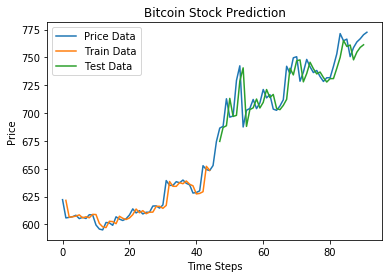

In [28]:
predict_prices(dataset)